<a href="https://colab.research.google.com/github/silverstar0727/1day-1commit-challenge/blob/master/%EC%B2%9C%EC%B2%B4%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 구글 드라이브 연동
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 연동 테스트 코드
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')

!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [0]:
# 필요한 라이브러리 import
# basic
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re

# plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 경고메세지 무시
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# fold
from sklearn.model_selection import KFold,StratifiedKFold

# 모델
from xgboost import XGBClassifier
import xgboost
# 평가방법
import sklearn
from sklearn.metrics import log_loss

In [0]:
# 데이터 읽기
#EDA 데이터
eda = pd.read_csv('/content/gdrive/My Drive/dacon stage 2 data/train.csv')

train = pd.read_csv('/content/gdrive/My Drive/dacon stage 2 data/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/dacon stage 2 data/test.csv')
sample_submission = pd.read_csv('/content/gdrive/My Drive/dacon stage 2 data/sample_submission.csv')

In [0]:
# type별 비율 확인
train['type'].value_counts() # list의 기본 method인 values count를 통해 확인

QSO                    49680
GALAXY                 37347
SERENDIPITY_BLUE       21760
SPECTROPHOTO_STD       14630
REDDEN_STD             14618
STAR_RED_DWARF         13750
STAR_BHB               13500
SERENDIPITY_FIRST       7132
ROSAT_D                 6580
STAR_CATY_VAR           6506
SERENDIPITY_DISTANT     4654
STAR_CARBON             3257
SERENDIPITY_RED         2562
STAR_WHITE_DWARF        2160
STAR_SUB_DWARF          1154
STAR_BROWN_DWARF         500
SKY                      127
SERENDIPITY_MANUAL        61
STAR_PN                   13
Name: type, dtype: int64

In [0]:
# data preprocessing

# data type 변경을 통한 메모리 줄이기
for col in train.columns:
  if train[col].dtype == 'float64':
    train[col] = train[col].astype('float32')
  if train[col].dtype == 'int64':
    train[col] = train[col].astype('int32')

for col in test.columns:
  if test[col].dtype == 'float64':
    test[col] = test[col].astype('float32')
  if test[col].dtype == 'int64':
    test[col] = test[col].astype('int32')

In [0]:
# train data의 column을 tc에 저장
tc = np.array(train.columns)

# id와 type, fiberID는 영향을 크게 주지 않으므로 tc항목에서 제거
tc = tc[3:]
tc

array(['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r',
       'petroMag_i', 'petroMag_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z'], dtype=object)

In [0]:
types = ['QSO', 'GALAXY', 'SERENDIPITY_BLUE', 'SPECTROPHOTO_STD',
        'REDDEN_STD', 'STAR_RED_DWARF', 'STAR_BHB', 'SERENDIPITY_FIRST',
        'ROSAT_D', 'STAR_CATY_VAR', 'SERENDIPITY_DISTANT', 'STAR_CARBON',
        'SERENDIPITY_RED', 'STAR_WHITE_DWARF', 'STAR_SUB_DWARF',
        'STAR_BROWN_DWARF', 'SKY', 'SERENDIPITY_MANUAL', 'STAR_PN']

In [0]:
# groupby로 type별 데이터 나열
q = train.groupby('type')

In [0]:
QSO = train[train['type'].isin(['QSO'])] #49680
GALAXY = train[train['type'].isin(['GALAXY'])] #37347
SB = train[train['type'].isin(['SERENDIPITY_BLUE'])] #21760
SS = train[train['type'].isin(['SPECTROPHOTO_STD'])] #14630
RS = train[train['type'].isin(['REDDEN_STD'])] #14618
SRD = train[train['type'].isin(['STAR_RED_DWARF'])] #13750
S_BHB = train[train['type'].isin(['STAR_BHB'])] #13500
SF = train[train['type'].isin(['SERENDIPITY_FIRST'])] #7132
RD = train[train['type'].isin(['ROSAT_D'])] # 6580
SCV = train[train['type'].isin(['STAR_CATY_VAR'])] #6506
SD = train[train['type'].isin(['SERENDIPITY_DISTANT'])] #4654
SC = train[train['type'].isin(['STAR_CARBON'])] #3257
SR = train[train['type'].isin(['SERENDIPITY_RED'])] #2562
SWD = train[train['type'].isin(['STAR_WHITE_DWARF'])] #2160
SSD = train[train['type'].isin(['STAR_SUB_DWARF'])] #1154
SBD = train[train['type'].isin(['STAR_BROWN_DWARF'])] #500
SKY = train[train['type'].isin(['SKY'])] #127
SM = train[train['type'].isin(['SERENDIPITY_MANUAL'])] #61
SP = train[train['type'].isin(['STAR_PN'])] #13

In [0]:
type1 = [QSO,GALAXY,SB,SS,RS,SRD,S_BHB,SF,RD,SCV,SD,SC,SR,SWD,SSD,SBD,SKY,SM,SP]

In [0]:
# 이상치 잘라내기 & 정규화(normalization)
for i in list(tc):
  #이상치 제거
  train = train[(train[i] > 0) & (train[i]<50)]
  #normalization
  min = pd.Series.min(train[i])
  max = pd.Series.max(train[i])
  train[i] = (train[i] - min) / (max - min)

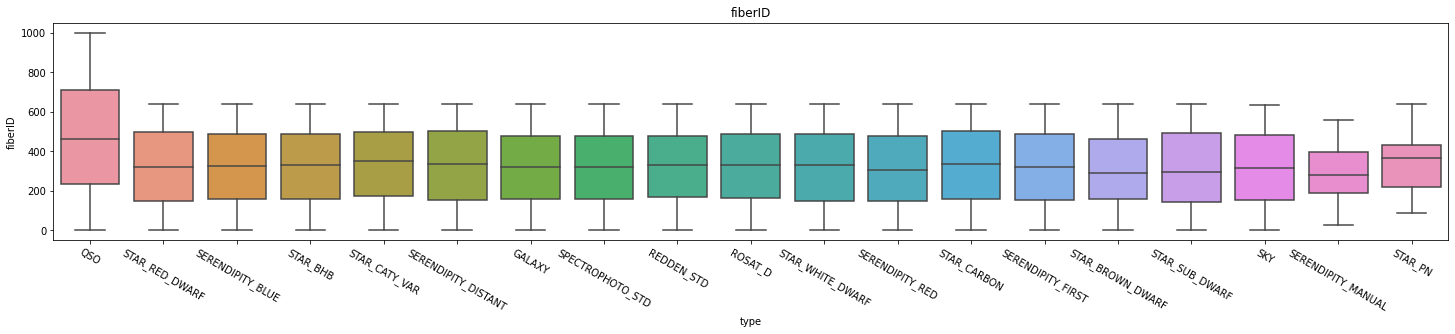

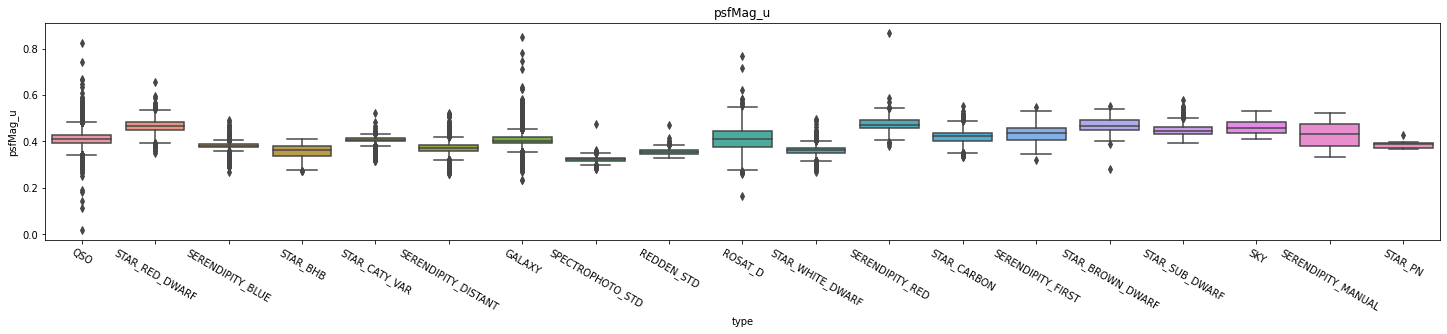

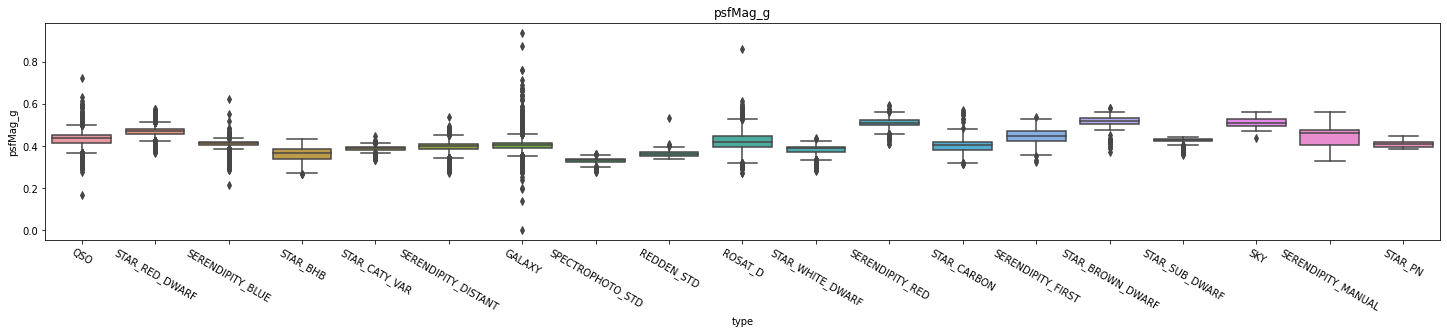

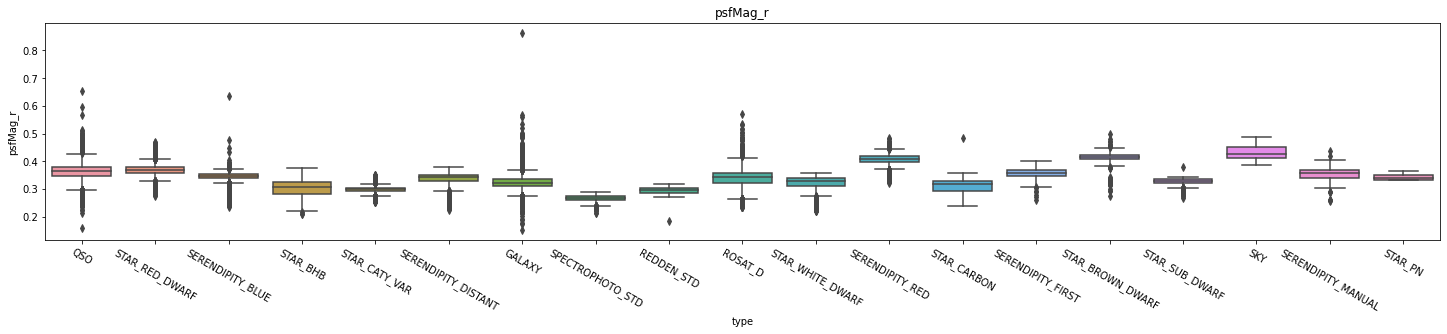

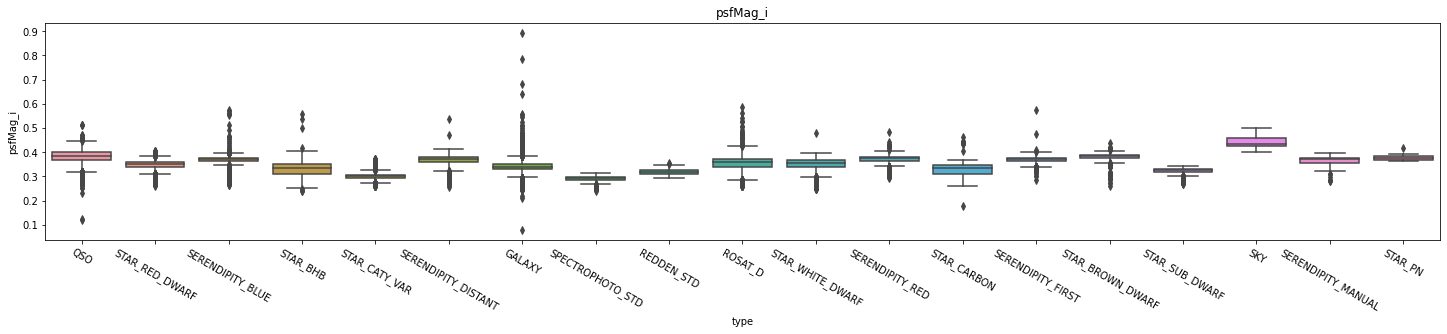

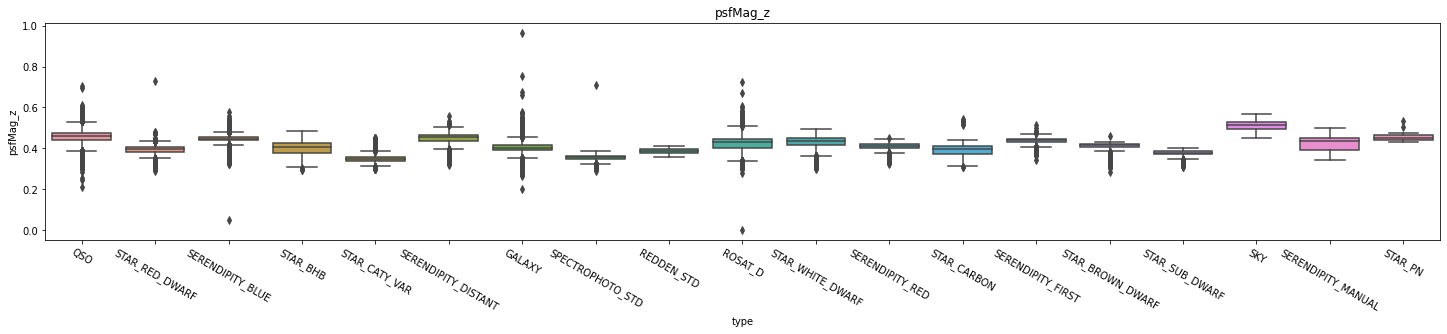

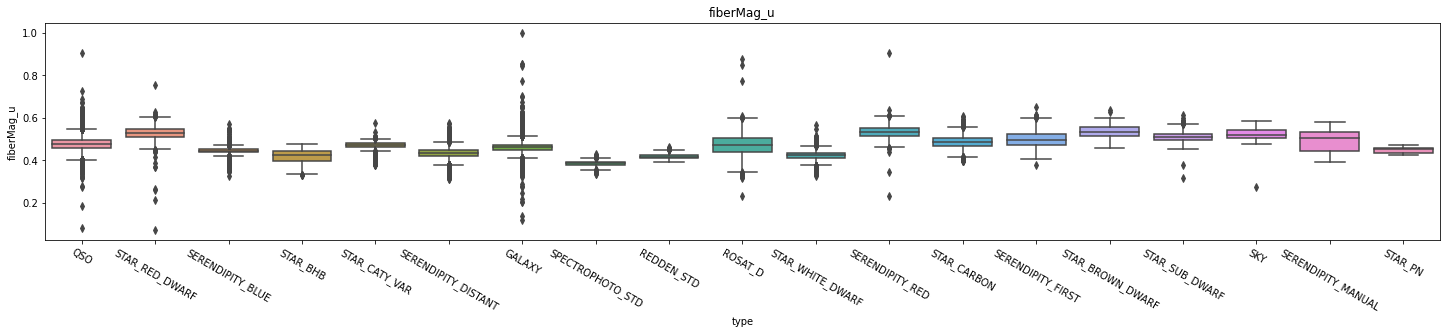

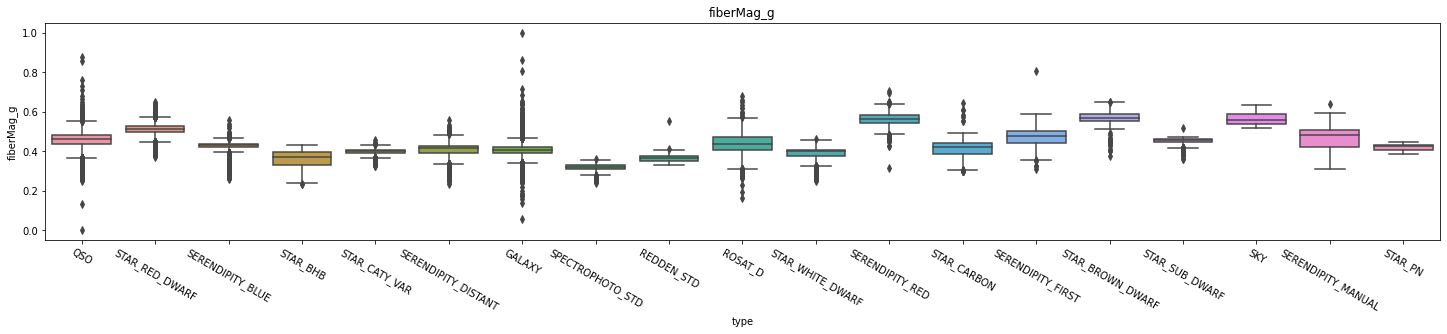

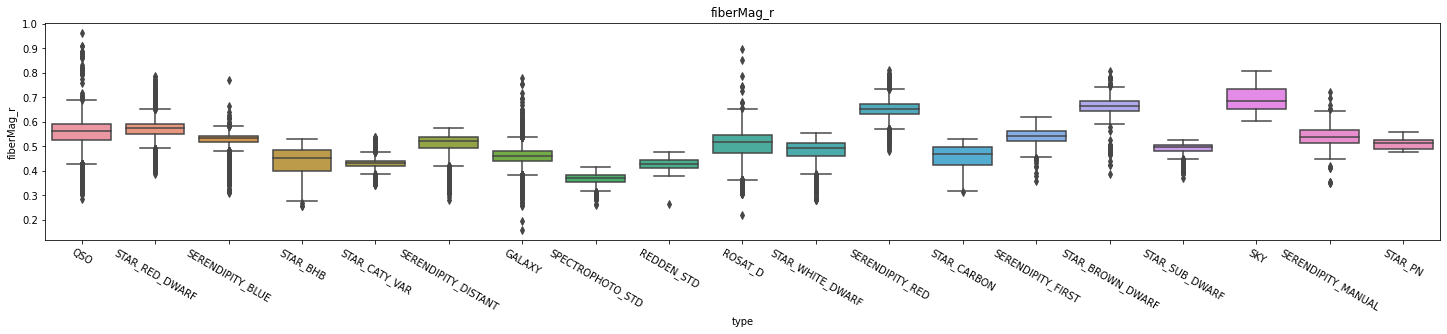

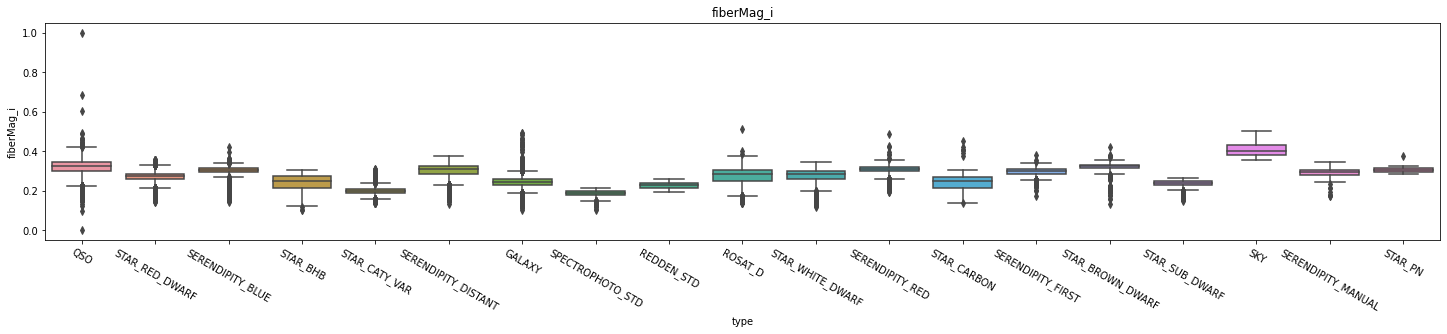

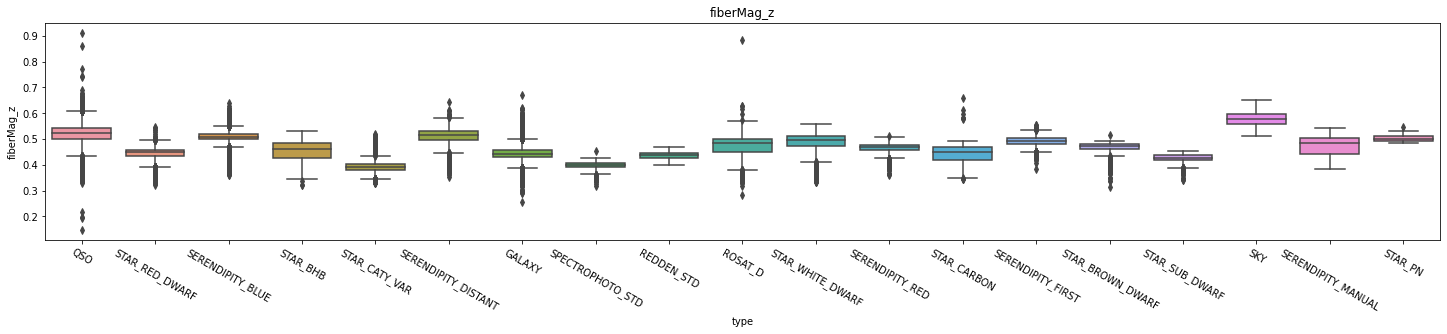

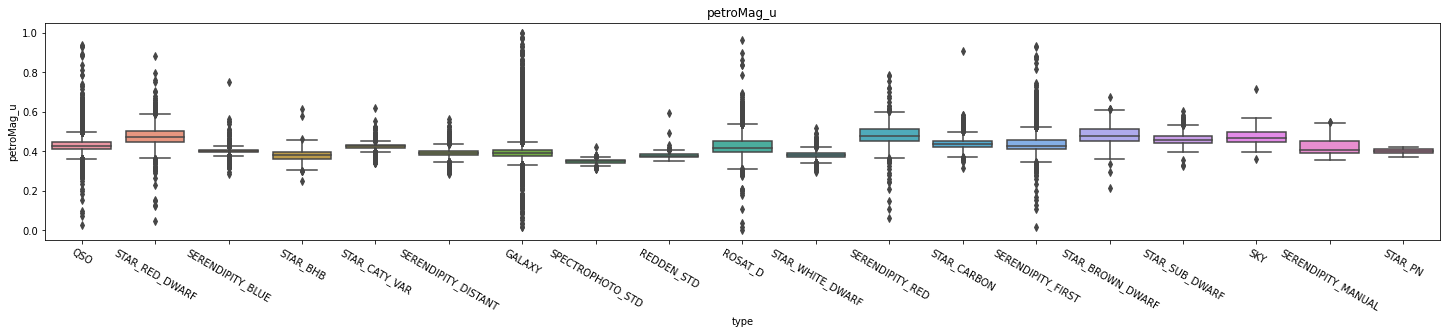

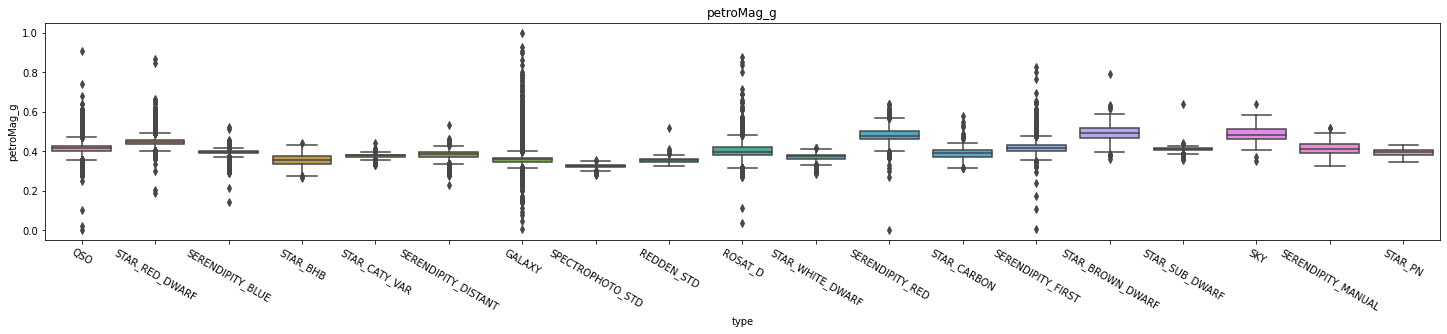

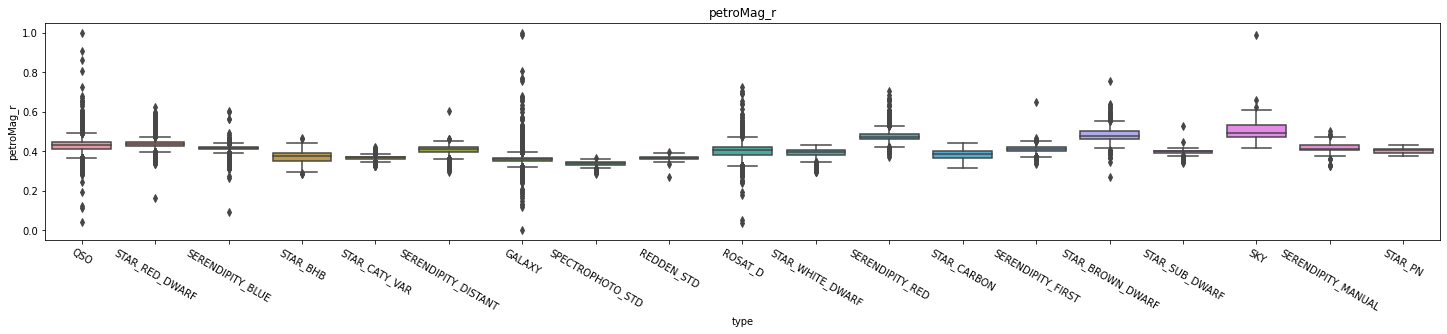

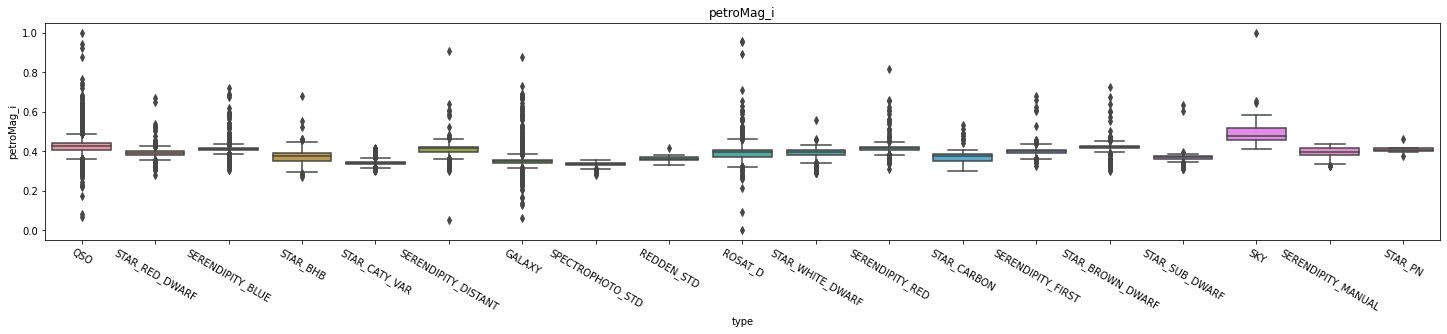

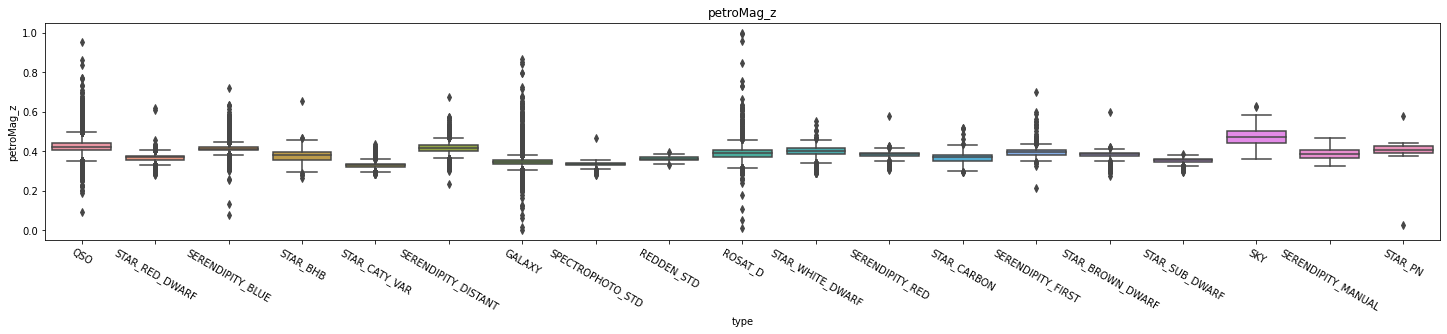

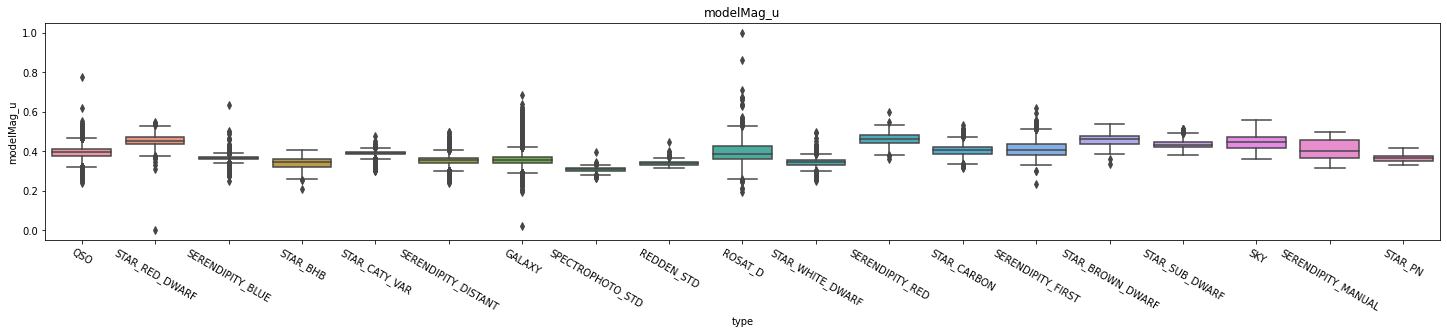

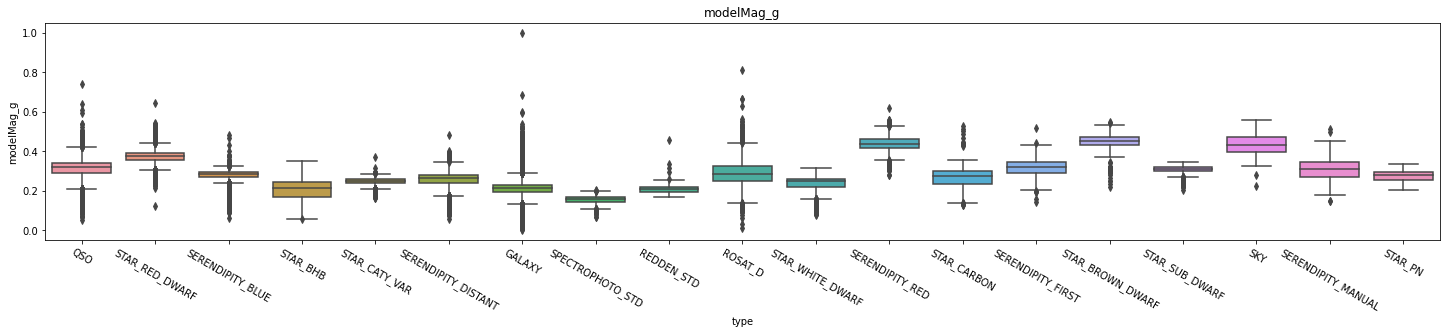

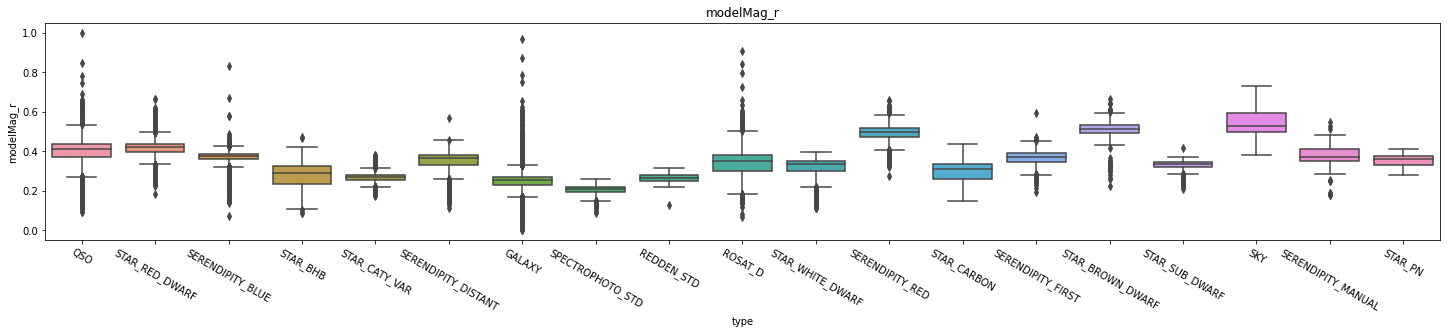

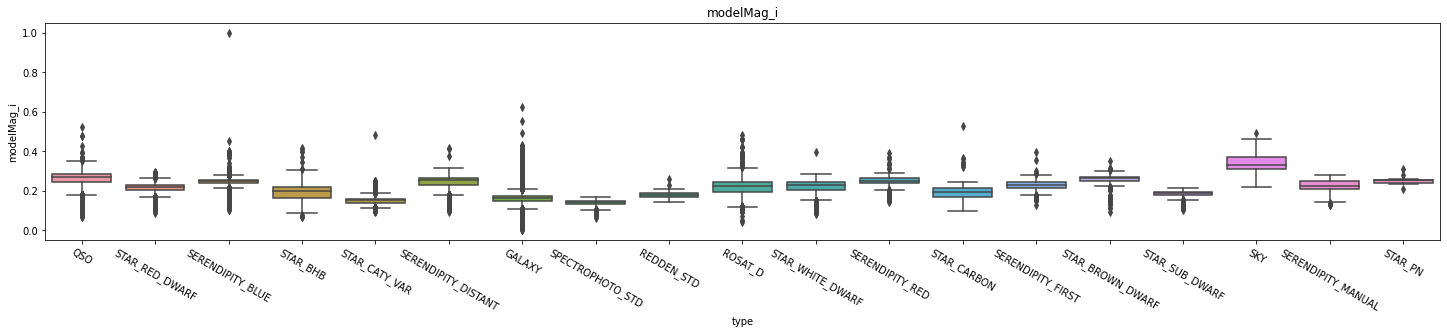

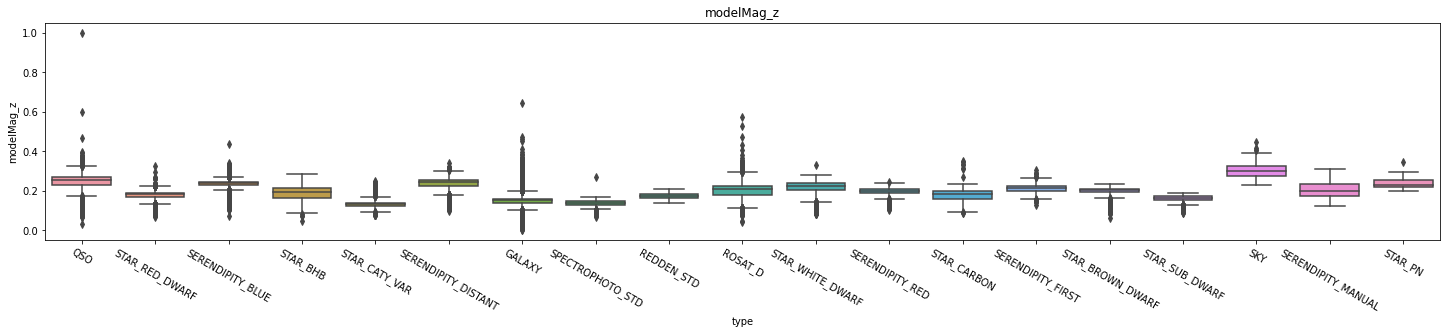

In [0]:
for col in train.columns[2:]:
  plt.figure(figsize=(25,4))
  sns.boxplot(x='type',y=col,data=train)
  plt.title(col)
  plt.xticks(rotation=-30)
  plt.show()

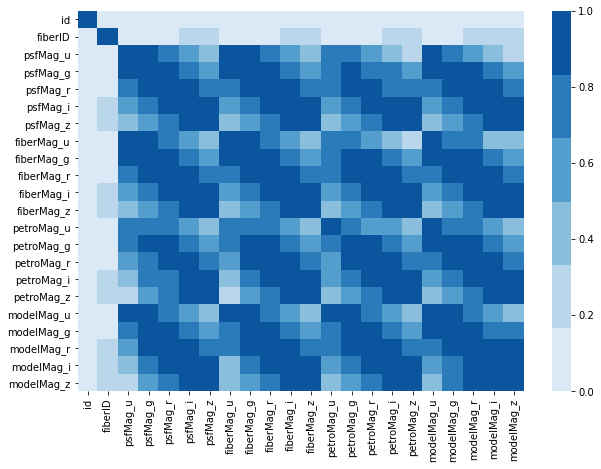

In [0]:
# 전체 데이터에 대한 상관관계 HeatMap 시각화
corr = train.corr()
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)